In [ ]:
!pip install nltk
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import re
from gensim.utils import tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            feat_dict = {}
            #feat_dict['col1'] = line[3]
            #feat_dict['col2'] = line[4]
            #feat_dict['col3'] = line[5]
            #feat_dict['col4'] = line[6]
            #feat_dict['col5'] = line[7]
            #feat_dict['col6'] = line[8]
            feat_dict['col7'] = line[9]
            #feat_dict['col8'] = line[10]
            #feat_dict['col9'] = line[11]
            #feat_dict['col10'] = line[12]
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(lemmetize(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(lemmetize(text)),label))

In [ ]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]

def parse_data_line(data_line):
    label = convert_label(data_line[1])
    text = data_line[2]
    return (label,text)

In [ ]:
# Input: a string of one statement

def pre_process(text):
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) 
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    tokens = re.split(r"\s+",text)
    tokens = [t.lower() for t in tokens] 

    boole = False

    if boole:
      no_stpwords_string=""
      for i in tokens:
        if i not in stop_words:
          no_stpwords_string += i+' '
      tokens = [no_stpwords_string[:-1]]   
    return tokens


lemmatizer = WordNetLemmatizer()

def lemmetize(tokens):
     l1 = []
     tokens = pre_process(tokens)
     for token in tokens:
          tokens = lemmatizer.lemmatize(token)
          l1.append(tokens)
     return l1

In [ ]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    #Should return a dictionary containing features as keys, and weights as values
    #DESCRIBE YOUR METHOD IN WORDS
    fn_dictionary = {}
    for x in tokens:
        if x in fn_dictionary:
            fn_dictionary[x] += 1
        else:
            fn_dictionary[x] = 1
    
    return fn_dictionary

In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(C=0.0001))])
    return SklearnClassifier(pipeline).train(data)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

fold_testdata = []
fold_predictdata = []
fold_textdata = []

def cross_validate(dataset, folds):
    precision = []
    recall = []
    f1 = []
    accuracy = []
    results = []
    fold_size = int(len(dataset)/folds) + 1
    cv_results = []
    j = 0


    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        data_fold = dataset[0:i]+dataset[i+fold_size:len(dataset)]
        test_fold = dataset[i:i+fold_size]
        print('Fold start on  %d - %d'%(i,i+fold_size))
        
        
        classifier = train_classifier(data_fold)
        pred = predict_labels([x[0] for x in test_fold],classifier)
        # FILL IN THE METHOD HERE
        
        accuracy.append(accuracy_score([x[1] for x in test_fold],pred))
        (a,b,c,none) = precision_recall_fscore_support([x[1] for x in test_fold],pred,average='macro')
        precision = np.append(precision,a)
        recall = np.append(recall,b)
        f1 = np.append(f1,c)        
    
        if i == 3280:
          fold_testdata.append([x[1] for x in test_fold])
          fold_predictdata.append(pred)
          fold_textdata.append([x[0] for x in test_fold])


    cv_results = [np.mean(accuracy),np.mean(precision),np.mean(recall),np.mean(f1)]
        
    return cv_results


In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)


arr1 = np.array(raw_data)
res1 = list(arr1[:,0])
tokens1 = []
for i in res1:
    tokens1 = tokens1 + lemmetize(i)
global_feature_vector = to_feature_vector(tokens1)
print("global Feat",len(global_feature_vector))


# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_vector), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
global Feat 12082
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
12082


In [ ]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on  0 - 820
Training Classifier...
Fold start on  820 - 1640
Training Classifier...
Fold start on  1640 - 2460
Training Classifier...
Fold start on  2460 - 3280
Training Classifier...
Fold start on  3280 - 4100
Training Classifier...
Fold start on  4100 - 4920
Training Classifier...
Fold start on  4920 - 5740
Training Classifier...
Fold start on  5740 - 6560
Training Classifier...
Fold start on  6560 - 7380
Training Classifier...
Fold start on  7380 - 8200
Training Classifier...


[0.5731473026552926,
 0.5806784241253357,
 0.5143572395253331,
 0.4148546737231801]

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

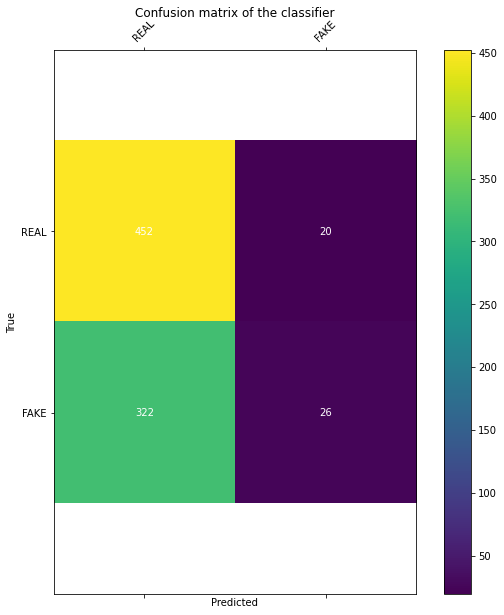

In [ ]:
confusion_matrix_heatmap(fold_testdata[0],fold_predictdata[0],['REAL','FAKE'])

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'the': 2, 'bush': 1, 'tax': 1, 'cut': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, '.': 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.599812
Recall: 0.565642
F Score:0.456277
